In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time

import os
import argparse
import pickle
from tqdm import tqdm

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform_train = transforms.Compose([
                                transforms.RandomCrop(32,padding=4),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
])
transform_test = transforms.Compose([
                                     transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
])

In [5]:
data = torchvision.datasets.CIFAR100(root='drive/My Drive',train=True,download=True,transform=transform_train)
batch = 128
num = data.__len__()
valid_size = 0.2
# Dividing the indices for train and cross validation
indices = list(range(num))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num))
train_idx,valid_idx = indices[split:], indices[:split]

#Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(data, batch_size = batch, sampler = train_sampler,num_workers=4)
valid_loader = torch.utils.data.DataLoader(data, batch_size = batch, sampler = valid_sampler,num_workers=4)


Files already downloaded and verified


In [6]:
test_data = torchvision.datasets.CIFAR100(root='drive/My Drive',train=False,download=True,transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch,shuffle=True,num_workers=4)

Files already downloaded and verified


In [7]:
classes=pickle.load(open('drive/My Drive/cifar-100-python/meta', 'rb'))
classes=classes['fine_label_names']
print(classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [0]:
def showimage(image):
  image = image/2+0.5
  image = image.cpu().numpy()
  return image.transpose(1,2,0)


dataiter = iter(train_loader)
images, labels = dataiter.next()

# fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
# for idx, image in enumerate(images):
#     axes[idx].imshow(showimage(image))
#     axes[idx].set_title(classes[labels[idx]])
#     axes[idx].set_xticks([])
#     axes[idx].set_yticks([])
# plt.imshow(showimage(images[0].squeeze(0)))

In [74]:
2048/128

16.0

In [0]:
class Model(nn.Module):
  def __init__(self):
    super(Model,self).__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(3,32,3,padding=1),
                               nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),
                                 nn.AvgPool2d(2,2))
    self.conv2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1),
                               nn.BatchNorm2d(64),
                                nn.ReLU(inplace=True),
                                 nn.AvgPool2d(2,2))
    self.conv3 = nn.Sequential(nn.Conv2d(64,128,3,padding=1),
                               nn.BatchNorm2d(128),
                                nn.ReLU(inplace=True),
                                 nn.AvgPool2d(2,2))
    self.conv4 = nn.Sequential(nn.Conv2d(128,256,3,padding=1),
                               nn.BatchNorm2d(256),
                                nn.ReLU(inplace=True),
                                 )
    
    self.fc1 = nn.Sequential(nn.Linear(256*4*4,1024),
                               nn.ReLU(inplace=True),
                              nn.Dropout())
    self.fc2 = nn.Sequential(nn.Linear(1024,256),
                               nn.ReLU(inplace=True),
                              nn.Dropout())
    self.fc3 = nn.Linear(256,100)

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    # print(x.shape)
    fc = x.view(x.size(0),-1)
    # print(fc.shape)
    fc = self.fc1(fc)
    fc = self.fc2(fc)
    out = self.fc3(fc)
    return out

In [223]:
train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)
model = Model().to(device)


True


In [0]:
optimizer = optim.Adam(model.parameters(),lr=1e-3,betas=[0.9,0.999])
# optimizer = optim.RMSprop(model.parameters(),lr=1e-3,weight_decay=5*1e-4)

error = nn.CrossEntropyLoss()
# error = nn.HingeEmbeddingLoss()

In [224]:
import os

model_directory_path = '/drive/My Drive/CIFAR-100 Classifier Using CNN in PyTorch/model/'
model_path = model_directory_path + 'cifar-100-cnn-model_batch_norm.pt'
if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)
n_epochs = 50
valid_loss_min = np.Inf

train_losses = []
valid_losses = []
trains_acc = []
vals_acc = []

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    total_train = 0
    correct_train = 0
    total_val = 0
    correct_val = 0
    
    model.train()
    start = time.time()
    for data,target in tqdm(train_loader):
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
#             clear the gradients of all optimized variables
        optimizer.zero_grad()
#         forward pass the model
        output = model(data)
#     backward pass the model
        loss = error(output,target)
        loss.backward()
#         Perform a single optimization step
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
      
        total_train += target.size(0)
        correct_train += (predicted == target).sum()
        train_loss += loss.item()*data.size(0)
        # end = time.time()
    #  end = time.time()
    
    print("Time Taken : ",time.time()-start)
    model.eval()
    with torch.no_grad():
      for data, target in valid_loader:
          
          if train_on_gpu:
              data, target = data.cuda(), target.cuda()
  #         forward pass now
          output = model(data)
  #         calculate the branch loss
          loss = error(output, target)
          _, predicted = torch.max(output.data, 1)
      
          total_val += target.size(0)
          correct_val += (predicted == target).sum()
  #     update average validation loss
          valid_loss += loss.item()*data.size(0)
    
    train_loss /= len(train_loader.sampler)
    # total_train /= len(train_loader.sampler)
    # correct_train /= len(train_loader.sampler)
    train_acc = correct_train.cpu().numpy()/total_train *100

    valid_loss /= len(valid_loader.sampler)
    # total_val /= len(valid_loader.sampler)
    # correct_val /= len(valid_loader.sampler)
    val_acc = correct_val.cpu().numpy()/total_val *100
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    trains_acc.append(train_acc)
    vals_acc.append(val_acc) 
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    print('Epoch: {} \tTraining Accuracy: {:.2f} \tValidation Accuarcy: {:.2f}'.format(
        epoch, train_acc, val_acc))
    if valid_loss <= valid_loss_min:
        print("Validation Loss decreased {:0.6f} -> {:0.6f}".format(valid_loss_min,valid_loss))
        valid_loss_min = valid_loss
        torch.save(model.state_dict(), model_path)








  0%|          | 0/313 [00:00<?, ?it/s]






  0%|          | 1/313 [00:00<01:37,  3.21it/s]






  1%|▏         | 4/313 [00:00<01:11,  4.33it/s]






  3%|▎         | 8/313 [00:00<00:52,  5.86it/s]






  4%|▎         | 11/313 [00:00<00:39,  7.72it/s]






  4%|▍         | 14/313 [00:00<00:30,  9.88it/s]






  6%|▌         | 18/313 [00:00<00:24, 12.28it/s]






  7%|▋         | 21/313 [00:01<00:20, 14.55it/s]






  8%|▊         | 24/313 [00:01<00:17, 16.51it/s]






  9%|▊         | 27/313 [00:01<00:15, 18.82it/s]






 10%|▉         | 30/313 [00:01<00:14, 19.84it/s]






 11%|█         | 33/313 [00:01<00:12, 21.74it/s]






 12%|█▏        | 37/313 [00:01<00:11, 25.00it/s]






 13%|█▎        | 40/313 [00:01<00:11, 24.81it/s]






 14%|█▎        | 43/313 [00:01<00:11, 24.09it/s]






 15%|█▍        | 46/313 [00:02<00:11, 22.70it/s]






 16%|█▌        | 49/313 [00:02<00:11, 23.44it/s]






 17%|█▋        | 52/313 [00:02<00:10, 24.17it/s]






 18%|█▊        

Time Taken :  11.85598111152649










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 0 	Training Loss: 4.614399 	Validation Loss: 4.607997
Epoch: 0 	Training Accuracy: 1.00 	Validation Accuarcy: 1.11
Validation Loss decreased inf -> 4.607997









  0%|          | 1/313 [00:00<01:46,  2.92it/s]






  2%|▏         | 5/313 [00:00<01:16,  4.00it/s]






  3%|▎         | 8/313 [00:00<00:56,  5.38it/s]






  3%|▎         | 10/313 [00:00<00:44,  6.88it/s]






  4%|▍         | 13/313 [00:00<00:33,  8.85it/s]






  5%|▌         | 16/313 [00:00<00:26, 11.14it/s]






  6%|▌         | 19/313 [00:01<00:21, 13.53it/s]






  7%|▋         | 22/313 [00:01<00:18, 15.58it/s]






  8%|▊         | 25/313 [00:01<00:16, 17.95it/s]






  9%|▉         | 28/313 [00:01<00:14, 19.69it/s]






 10%|█         | 32/313 [00:01<00:12, 21.63it/s]






 12%|█▏        | 36/313 [00:01<00:11, 24.31it/s]






 13%|█▎        | 40/313 [00:01<00:10, 25.70it/s]






 14%|█▎        | 43/313 [00:01<00:11, 24.48it/s]






 15%|█▍        | 46/313 [00:02<00:10, 25.25it/s]






 16%|█▌        | 50/313 [00:02<00:09, 27.55it/s]






 17%|█▋        | 53/313 [00:02<00:09, 26.34it/s]






 18%|█▊        | 56/313 [00:02<00:09, 25.86it/s]






 19%|█

Time Taken :  12.081424236297607










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 4.613548 	Validation Loss: 4.607782
Epoch: 1 	Training Accuracy: 0.95 	Validation Accuarcy: 1.02
Validation Loss decreased 4.607997 -> 4.607782









  0%|          | 1/313 [00:00<01:44,  2.97it/s]






  1%|▏         | 4/313 [00:00<01:16,  4.02it/s]






  2%|▏         | 7/313 [00:00<00:56,  5.42it/s]






  3%|▎         | 10/313 [00:00<00:42,  7.13it/s]






  4%|▍         | 13/313 [00:00<00:33,  8.97it/s]






  5%|▌         | 16/313 [00:00<00:26, 11.15it/s]






  6%|▌         | 19/313 [00:01<00:21, 13.44it/s]






  7%|▋         | 23/313 [00:01<00:18, 15.78it/s]






  8%|▊         | 26/313 [00:01<00:16, 17.72it/s]






  9%|▉         | 29/313 [00:01<00:14, 19.30it/s]






 10%|█         | 32/313 [00:01<00:13, 21.23it/s]






 11%|█         | 35/313 [00:01<00:12, 22.36it/s]






 12%|█▏        | 39/313 [00:01<00:11, 24.07it/s]






 14%|█▎        | 43/313 [00:01<00:10, 24.96it/s]






 15%|█▌        | 47/313 [00:02<00:10, 26.09it/s]






 16%|█▌        | 50/313 [00:02<00:09, 26.35it/s]






 17%|█▋        | 53/313 [00:02<00:10, 25.52it/s]






 18%|█▊        | 56/313 [00:02<00:10, 24.95it/s]






 19%|█

Time Taken :  11.82475996017456










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 4.614826 	Validation Loss: 4.607679
Epoch: 2 	Training Accuracy: 0.97 	Validation Accuarcy: 1.02
Validation Loss decreased 4.607782 -> 4.607679









  0%|          | 1/313 [00:00<01:36,  3.23it/s]






  1%|          | 3/313 [00:00<01:11,  4.31it/s]






  2%|▏         | 6/313 [00:00<00:52,  5.80it/s]






  3%|▎         | 9/313 [00:00<00:40,  7.59it/s]






  4%|▍         | 12/313 [00:00<00:30,  9.78it/s]






  5%|▍         | 15/313 [00:00<00:25, 11.89it/s]






  6%|▌         | 19/313 [00:00<00:20, 14.41it/s]






  7%|▋         | 22/313 [00:01<00:18, 16.09it/s]






  8%|▊         | 25/313 [00:01<00:15, 18.23it/s]






  9%|▉         | 28/313 [00:01<00:14, 19.53it/s]






 10%|▉         | 31/313 [00:01<00:14, 19.77it/s]






 11%|█         | 34/313 [00:01<00:13, 21.00it/s]






 12%|█▏        | 37/313 [00:01<00:12, 22.09it/s]






 13%|█▎        | 40/313 [00:01<00:12, 21.79it/s]






 14%|█▎        | 43/313 [00:02<00:11, 22.70it/s]






 15%|█▍        | 46/313 [00:02<00:11, 24.04it/s]






 16%|█▌        | 49/313 [00:02<00:10, 25.10it/s]






 17%|█▋        | 53/313 [00:02<00:09, 27.76it/s]






 18%|█▊

Time Taken :  11.81650447845459










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 4.614082 	Validation Loss: 4.607490
Epoch: 3 	Training Accuracy: 0.91 	Validation Accuarcy: 1.07
Validation Loss decreased 4.607679 -> 4.607490









  0%|          | 1/313 [00:00<01:43,  3.01it/s]






  1%|▏         | 4/313 [00:00<01:15,  4.08it/s]






  2%|▏         | 7/313 [00:00<00:55,  5.48it/s]






  3%|▎         | 10/313 [00:00<00:42,  7.17it/s]






  4%|▍         | 14/313 [00:00<00:32,  9.31it/s]






  6%|▌         | 18/313 [00:00<00:25, 11.71it/s]






  7%|▋         | 21/313 [00:01<00:20, 14.08it/s]






  8%|▊         | 25/313 [00:01<00:16, 16.98it/s]






  9%|▉         | 28/313 [00:01<00:15, 18.56it/s]






 10%|▉         | 31/313 [00:01<00:14, 19.90it/s]






 11%|█         | 34/313 [00:01<00:12, 22.13it/s]






 12%|█▏        | 37/313 [00:01<00:11, 23.24it/s]






 13%|█▎        | 40/313 [00:01<00:10, 24.92it/s]






 14%|█▎        | 43/313 [00:01<00:10, 25.84it/s]






 15%|█▍        | 46/313 [00:01<00:09, 26.91it/s]






 16%|█▌        | 50/313 [00:02<00:08, 29.62it/s]






 17%|█▋        | 54/313 [00:02<00:08, 30.19it/s]






 19%|█▊        | 58/313 [00:02<00:09, 27.13it/s]






 19%|█

Time Taken :  11.901497602462769










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 4.614309 	Validation Loss: 4.607977
Epoch: 4 	Training Accuracy: 0.97 	Validation Accuarcy: 0.94









  0%|          | 1/313 [00:00<01:52,  2.78it/s]






  2%|▏         | 5/313 [00:00<01:20,  3.81it/s]






  3%|▎         | 8/313 [00:00<00:59,  5.11it/s]






  4%|▎         | 11/313 [00:00<00:45,  6.65it/s]






  4%|▍         | 14/313 [00:00<00:34,  8.60it/s]






  5%|▌         | 17/313 [00:00<00:27, 10.81it/s]






  6%|▋         | 20/313 [00:01<00:22, 13.29it/s]






  7%|▋         | 23/313 [00:01<00:18, 15.56it/s]






  8%|▊         | 26/313 [00:01<00:16, 17.40it/s]






  9%|▉         | 29/313 [00:01<00:14, 19.23it/s]






 10%|█         | 32/313 [00:01<00:13, 20.88it/s]






 11%|█         | 35/313 [00:01<00:12, 21.55it/s]






 12%|█▏        | 38/313 [00:01<00:11, 23.30it/s]






 13%|█▎        | 41/313 [00:01<00:11, 22.90it/s]






 14%|█▍        | 44/313 [00:02<00:11, 23.38it/s]






 15%|█▌        | 47/313 [00:02<00:11, 24.07it/s]






 16%|█▋        | 51/313 [00:02<00:10, 25.98it/s]






 17%|█▋        | 54/313 [00:02<00:09, 26.96it/s]






 19%|█

Time Taken :  12.290090322494507










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 4.614147 	Validation Loss: 4.607492
Epoch: 5 	Training Accuracy: 1.04 	Validation Accuarcy: 0.97









  0%|          | 1/313 [00:00<01:35,  3.27it/s]






  2%|▏         | 5/313 [00:00<01:08,  4.50it/s]






  3%|▎         | 10/313 [00:00<00:50,  6.02it/s]






  4%|▍         | 14/313 [00:00<00:37,  8.03it/s]






  6%|▌         | 18/313 [00:00<00:29,  9.99it/s]






  7%|▋         | 21/313 [00:00<00:23, 12.28it/s]






  8%|▊         | 24/313 [00:01<00:19, 14.53it/s]






  9%|▊         | 27/313 [00:01<00:17, 16.58it/s]






 10%|▉         | 30/313 [00:01<00:15, 18.52it/s]






 11%|█         | 34/313 [00:01<00:14, 19.80it/s]






 12%|█▏        | 38/313 [00:01<00:12, 22.27it/s]






 13%|█▎        | 41/313 [00:01<00:11, 23.77it/s]






 14%|█▍        | 44/313 [00:01<00:10, 25.01it/s]






 15%|█▌        | 47/313 [00:01<00:10, 25.54it/s]






 16%|█▋        | 51/313 [00:02<00:09, 27.89it/s]






 17%|█▋        | 54/313 [00:02<00:09, 28.17it/s]






 18%|█▊        | 57/313 [00:02<00:10, 24.41it/s]






 19%|█▉        | 60/313 [00:02<00:10, 23.27it/s]






 20%|

Time Taken :  11.892584085464478









  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 4.613728 	Validation Loss: 4.608128
Epoch: 6 	Training Accuracy: 1.01 	Validation Accuarcy: 1.03









  0%|          | 1/313 [00:00<01:22,  3.78it/s]






  1%|          | 3/313 [00:00<01:02,  4.95it/s]






  2%|▏         | 6/313 [00:00<00:46,  6.54it/s]






  3%|▎         | 9/313 [00:00<00:35,  8.46it/s]






  4%|▍         | 13/313 [00:00<00:28, 10.71it/s]






  5%|▌         | 17/313 [00:00<00:22, 13.26it/s]






  7%|▋         | 21/313 [00:01<00:18, 16.06it/s]






  8%|▊         | 24/313 [00:01<00:15, 18.27it/s]






  9%|▉         | 28/313 [00:01<00:13, 20.84it/s]






 10%|▉         | 31/313 [00:01<00:13, 21.17it/s]






 11%|█         | 35/313 [00:01<00:12, 22.61it/s]






 12%|█▏        | 38/313 [00:01<00:12, 22.10it/s]






 13%|█▎        | 41/313 [00:01<00:12, 22.62it/s]






 14%|█▍        | 45/313 [00:01<00:11, 24.32it/s]






 16%|█▌        | 49/313 [00:02<00:10, 25.16it/s]






 17%|█▋        | 53/313 [00:02<00:09, 26.80it/s]






 18%|█▊        | 57/313 [00:02<00:09, 27.23it/s]






 19%|█▉        | 60/313 [00:02<00:09, 27.81it/s]






 20%|██

Time Taken :  11.92211627960205










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 4.615033 	Validation Loss: 4.607615
Epoch: 7 	Training Accuracy: 0.92 	Validation Accuarcy: 1.06









  0%|          | 1/313 [00:00<01:38,  3.17it/s]






  1%|▏         | 4/313 [00:00<01:11,  4.31it/s]






  3%|▎         | 8/313 [00:00<00:52,  5.79it/s]






  4%|▎         | 11/313 [00:00<00:39,  7.62it/s]






  4%|▍         | 14/313 [00:00<00:31,  9.57it/s]






  5%|▌         | 17/313 [00:00<00:24, 11.89it/s]






  6%|▋         | 20/313 [00:01<00:20, 14.41it/s]






  8%|▊         | 24/313 [00:01<00:16, 17.12it/s]






  9%|▉         | 28/313 [00:01<00:14, 20.18it/s]






 10%|█         | 32/313 [00:01<00:12, 23.27it/s]






 12%|█▏        | 36/313 [00:01<00:11, 23.63it/s]






 12%|█▏        | 39/313 [00:01<00:11, 23.58it/s]






 13%|█▎        | 42/313 [00:01<00:12, 22.05it/s]






 14%|█▍        | 45/313 [00:01<00:11, 22.43it/s]






 16%|█▌        | 49/313 [00:02<00:10, 24.02it/s]






 17%|█▋        | 52/313 [00:02<00:10, 25.10it/s]






 18%|█▊        | 55/313 [00:02<00:09, 26.27it/s]






 19%|█▊        | 58/313 [00:02<00:09, 25.53it/s]






 19%|█

Time Taken :  11.663063049316406










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 4.613942 	Validation Loss: 4.608291
Epoch: 8 	Training Accuracy: 1.03 	Validation Accuarcy: 1.04









  0%|          | 1/313 [00:00<01:38,  3.16it/s]






  2%|▏         | 5/313 [00:00<01:11,  4.32it/s]






  3%|▎         | 9/313 [00:00<00:52,  5.81it/s]






  4%|▍         | 13/313 [00:00<00:39,  7.65it/s]






  5%|▌         | 16/313 [00:00<00:30,  9.81it/s]






  6%|▋         | 20/313 [00:00<00:23, 12.40it/s]






  8%|▊         | 24/313 [00:01<00:19, 15.09it/s]






  9%|▊         | 27/313 [00:01<00:16, 16.90it/s]






 10%|▉         | 30/313 [00:01<00:15, 18.25it/s]






 11%|█         | 33/313 [00:01<00:13, 20.00it/s]






 12%|█▏        | 36/313 [00:01<00:12, 21.48it/s]






 12%|█▏        | 39/313 [00:01<00:12, 22.34it/s]






 13%|█▎        | 42/313 [00:01<00:12, 22.47it/s]






 15%|█▍        | 46/313 [00:01<00:10, 24.45it/s]






 16%|█▌        | 50/313 [00:02<00:10, 25.85it/s]






 17%|█▋        | 53/313 [00:02<00:10, 24.73it/s]






 18%|█▊        | 56/313 [00:02<00:10, 25.06it/s]






 19%|█▉        | 59/313 [00:02<00:10, 24.61it/s]






 20%|█

Time Taken :  12.051398277282715










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 4.614254 	Validation Loss: 4.607866
Epoch: 9 	Training Accuracy: 0.92 	Validation Accuarcy: 0.97









  0%|          | 1/313 [00:00<01:39,  3.14it/s]






  2%|▏         | 5/313 [00:00<01:11,  4.31it/s]






  3%|▎         | 9/313 [00:00<00:53,  5.70it/s]






  4%|▍         | 12/313 [00:00<00:40,  7.48it/s]






  5%|▍         | 15/313 [00:00<00:31,  9.49it/s]






  6%|▌         | 18/313 [00:00<00:25, 11.61it/s]






  7%|▋         | 21/313 [00:01<00:21, 13.57it/s]






  8%|▊         | 25/313 [00:01<00:18, 15.86it/s]






  9%|▉         | 29/313 [00:01<00:14, 18.95it/s]






 10%|█         | 32/313 [00:01<00:13, 21.22it/s]






 11%|█         | 35/313 [00:01<00:11, 23.20it/s]






 12%|█▏        | 38/313 [00:01<00:11, 23.55it/s]






 13%|█▎        | 41/313 [00:01<00:11, 24.09it/s]






 14%|█▍        | 44/313 [00:01<00:11, 24.31it/s]






 15%|█▌        | 47/313 [00:02<00:10, 25.65it/s]






 16%|█▌        | 50/313 [00:02<00:10, 24.86it/s]






 17%|█▋        | 53/313 [00:02<00:10, 23.67it/s]






 18%|█▊        | 56/313 [00:02<00:10, 23.82it/s]






 19%|█

Time Taken :  12.003574848175049










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 4.613226 	Validation Loss: 4.607705
Epoch: 10 	Training Accuracy: 1.07 	Validation Accuarcy: 0.95









  0%|          | 1/313 [00:00<01:43,  3.03it/s]






  2%|▏         | 5/313 [00:00<01:14,  4.15it/s]






  3%|▎         | 9/313 [00:00<00:54,  5.62it/s]






  4%|▍         | 12/313 [00:00<00:40,  7.40it/s]






  5%|▍         | 15/313 [00:00<00:32,  9.31it/s]






  6%|▌         | 18/313 [00:00<00:25, 11.44it/s]






  7%|▋         | 22/313 [00:01<00:20, 14.24it/s]






  8%|▊         | 25/313 [00:01<00:17, 16.58it/s]






  9%|▉         | 29/313 [00:01<00:14, 19.21it/s]






 11%|█         | 33/313 [00:01<00:13, 21.51it/s]






 12%|█▏        | 37/313 [00:01<00:11, 23.44it/s]






 13%|█▎        | 41/313 [00:01<00:10, 24.80it/s]






 14%|█▍        | 44/313 [00:01<00:10, 24.69it/s]






 15%|█▌        | 47/313 [00:01<00:10, 25.37it/s]






 16%|█▌        | 50/313 [00:02<00:10, 25.13it/s]






 17%|█▋        | 54/313 [00:02<00:09, 27.09it/s]






 19%|█▊        | 58/313 [00:02<00:09, 27.67it/s]






 20%|█▉        | 62/313 [00:02<00:08, 28.48it/s]






 21%|█

Time Taken :  12.093258142471313










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 4.613888 	Validation Loss: 4.607799
Epoch: 11 	Training Accuracy: 0.97 	Validation Accuarcy: 1.09









  0%|          | 1/313 [00:00<01:55,  2.70it/s]






  1%|▏         | 4/313 [00:00<01:24,  3.66it/s]






  2%|▏         | 7/313 [00:00<01:01,  4.96it/s]






  3%|▎         | 10/313 [00:00<00:46,  6.53it/s]






  4%|▍         | 13/313 [00:00<00:35,  8.48it/s]






  5%|▌         | 16/313 [00:00<00:27, 10.72it/s]






  6%|▋         | 20/313 [00:01<00:21, 13.46it/s]






  7%|▋         | 23/313 [00:01<00:18, 15.77it/s]






  8%|▊         | 26/313 [00:01<00:15, 18.28it/s]






  9%|▉         | 29/313 [00:01<00:14, 20.12it/s]






 11%|█         | 33/313 [00:01<00:12, 22.30it/s]






 12%|█▏        | 37/313 [00:01<00:11, 25.08it/s]






 13%|█▎        | 40/313 [00:01<00:10, 25.84it/s]






 14%|█▎        | 43/313 [00:01<00:10, 25.50it/s]






 15%|█▍        | 46/313 [00:01<00:10, 25.20it/s]






 16%|█▌        | 50/313 [00:02<00:09, 26.31it/s]






 17%|█▋        | 54/313 [00:02<00:09, 27.68it/s]






 19%|█▊        | 58/313 [00:02<00:09, 27.68it/s]






 19%|█

Time Taken :  11.82807469367981









  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 4.613971 	Validation Loss: 4.607582
Epoch: 12 	Training Accuracy: 1.00 	Validation Accuarcy: 1.07









  0%|          | 1/313 [00:00<01:53,  2.75it/s]






  1%|          | 3/313 [00:00<01:24,  3.69it/s]






  2%|▏         | 6/313 [00:00<01:01,  5.00it/s]






  3%|▎         | 9/313 [00:00<00:46,  6.60it/s]






  4%|▍         | 12/313 [00:00<00:35,  8.42it/s]






  5%|▍         | 15/313 [00:00<00:27, 10.65it/s]






  6%|▌         | 18/313 [00:01<00:22, 13.08it/s]






  7%|▋         | 21/313 [00:01<00:18, 15.52it/s]






  8%|▊         | 24/313 [00:01<00:16, 17.18it/s]






  9%|▊         | 27/313 [00:01<00:14, 19.13it/s]






 10%|▉         | 30/313 [00:01<00:13, 21.20it/s]






 11%|█         | 33/313 [00:01<00:13, 21.52it/s]






 12%|█▏        | 36/313 [00:01<00:12, 22.39it/s]






 12%|█▏        | 39/313 [00:01<00:11, 23.44it/s]






 13%|█▎        | 42/313 [00:01<00:10, 24.97it/s]






 14%|█▍        | 45/313 [00:02<00:10, 25.23it/s]






 15%|█▌        | 48/313 [00:02<00:10, 26.45it/s]






 16%|█▋        | 51/313 [00:02<00:09, 26.72it/s]






 18%|█▊

Time Taken :  12.094629526138306










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 4.615121 	Validation Loss: 4.608282
Epoch: 13 	Training Accuracy: 0.97 	Validation Accuarcy: 0.97









  0%|          | 1/313 [00:00<01:52,  2.76it/s]






  1%|▏         | 4/313 [00:00<01:22,  3.76it/s]






  2%|▏         | 7/313 [00:00<01:00,  5.07it/s]






  3%|▎         | 10/313 [00:00<00:45,  6.72it/s]






  4%|▍         | 13/313 [00:00<00:35,  8.51it/s]






  5%|▌         | 16/313 [00:00<00:27, 10.77it/s]






  6%|▌         | 19/313 [00:01<00:22, 13.02it/s]






  7%|▋         | 22/313 [00:01<00:20, 14.15it/s]






  8%|▊         | 25/313 [00:01<00:18, 15.71it/s]






  9%|▉         | 28/313 [00:01<00:16, 17.74it/s]






 10%|▉         | 31/313 [00:01<00:13, 20.19it/s]






 11%|█         | 34/313 [00:01<00:13, 21.12it/s]






 12%|█▏        | 37/313 [00:01<00:12, 22.30it/s]






 13%|█▎        | 40/313 [00:01<00:11, 23.60it/s]






 14%|█▍        | 44/313 [00:02<00:10, 25.10it/s]






 15%|█▌        | 48/313 [00:02<00:09, 26.67it/s]






 16%|█▋        | 51/313 [00:02<00:09, 26.37it/s]






 17%|█▋        | 54/313 [00:02<00:10, 25.27it/s]






 18%|█

Time Taken :  12.044426441192627










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 4.613964 	Validation Loss: 4.607982
Epoch: 14 	Training Accuracy: 0.99 	Validation Accuarcy: 1.02









  0%|          | 1/313 [00:00<01:49,  2.84it/s]






  1%|▏         | 4/313 [00:00<01:19,  3.87it/s]






  3%|▎         | 8/313 [00:00<00:57,  5.28it/s]






  4%|▍         | 12/313 [00:00<00:42,  7.07it/s]






  5%|▍         | 15/313 [00:00<00:33,  8.86it/s]






  6%|▌         | 18/313 [00:00<00:26, 11.04it/s]






  7%|▋         | 21/313 [00:01<00:21, 13.31it/s]






  8%|▊         | 24/313 [00:01<00:18, 15.23it/s]






  9%|▊         | 27/313 [00:01<00:16, 17.80it/s]






 10%|▉         | 30/313 [00:01<00:14, 18.93it/s]






 11%|█         | 33/313 [00:01<00:13, 21.03it/s]






 12%|█▏        | 36/313 [00:01<00:12, 22.65it/s]






 12%|█▏        | 39/313 [00:01<00:11, 23.97it/s]






 13%|█▎        | 42/313 [00:01<00:10, 24.88it/s]






 14%|█▍        | 45/313 [00:02<00:11, 23.82it/s]






 15%|█▌        | 48/313 [00:02<00:10, 24.67it/s]






 17%|█▋        | 52/313 [00:02<00:09, 27.14it/s]






 18%|█▊        | 56/313 [00:02<00:08, 28.68it/s]






 19%|█

Time Taken :  11.759567975997925










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 4.613699 	Validation Loss: 4.607898
Epoch: 15 	Training Accuracy: 0.97 	Validation Accuarcy: 0.98









  0%|          | 1/313 [00:00<01:47,  2.91it/s]






  1%|▏         | 4/313 [00:00<01:17,  3.98it/s]






  3%|▎         | 8/313 [00:00<00:56,  5.38it/s]






  4%|▍         | 12/313 [00:00<00:41,  7.22it/s]






  5%|▍         | 15/313 [00:00<00:31,  9.32it/s]






  6%|▌         | 19/313 [00:00<00:24, 11.89it/s]






  7%|▋         | 22/313 [00:01<00:20, 14.21it/s]






  8%|▊         | 26/313 [00:01<00:17, 16.53it/s]






  9%|▉         | 29/313 [00:01<00:16, 17.72it/s]






 10%|█         | 32/313 [00:01<00:14, 19.83it/s]






 11%|█         | 35/313 [00:01<00:13, 21.01it/s]






 12%|█▏        | 39/313 [00:01<00:11, 24.22it/s]






 14%|█▎        | 43/313 [00:01<00:09, 27.03it/s]






 15%|█▌        | 47/313 [00:01<00:09, 27.80it/s]






 16%|█▋        | 51/313 [00:02<00:09, 27.40it/s]






 17%|█▋        | 54/313 [00:02<00:09, 28.08it/s]






 18%|█▊        | 57/313 [00:02<00:09, 26.68it/s]






 19%|█▉        | 60/313 [00:02<00:09, 25.47it/s]






 20%|█

Time Taken :  11.90692663192749










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 4.613854 	Validation Loss: 4.607959
Epoch: 16 	Training Accuracy: 0.99 	Validation Accuarcy: 0.96









  0%|          | 1/313 [00:00<01:37,  3.19it/s]






  1%|▏         | 4/313 [00:00<01:11,  4.33it/s]






  3%|▎         | 8/313 [00:00<00:51,  5.87it/s]






  4%|▎         | 11/313 [00:00<00:39,  7.67it/s]






  5%|▍         | 15/313 [00:00<00:30,  9.79it/s]






  6%|▌         | 18/313 [00:00<00:24, 11.98it/s]






  7%|▋         | 21/313 [00:01<00:20, 14.32it/s]






  8%|▊         | 25/313 [00:01<00:16, 17.12it/s]






  9%|▉         | 28/313 [00:01<00:14, 19.16it/s]






 10%|█         | 32/313 [00:01<00:13, 21.41it/s]






 11%|█         | 35/313 [00:01<00:12, 22.51it/s]






 12%|█▏        | 38/313 [00:01<00:11, 23.27it/s]






 13%|█▎        | 41/313 [00:01<00:11, 22.75it/s]






 14%|█▍        | 45/313 [00:01<00:10, 24.55it/s]






 16%|█▌        | 49/313 [00:02<00:09, 26.46it/s]






 17%|█▋        | 53/313 [00:02<00:09, 26.90it/s]






 18%|█▊        | 57/313 [00:02<00:09, 28.04it/s]






 19%|█▉        | 61/313 [00:02<00:08, 28.35it/s]






 20%|█

Time Taken :  11.614038705825806










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 4.613086 	Validation Loss: 4.607567
Epoch: 17 	Training Accuracy: 0.95 	Validation Accuarcy: 0.97









  0%|          | 1/313 [00:00<01:47,  2.90it/s]






  1%|▏         | 4/313 [00:00<01:18,  3.96it/s]






  2%|▏         | 6/313 [00:00<00:58,  5.21it/s]






  3%|▎         | 9/313 [00:00<00:44,  6.89it/s]






  4%|▍         | 12/313 [00:00<00:33,  8.88it/s]






  5%|▍         | 15/313 [00:00<00:26, 11.16it/s]






  6%|▌         | 18/313 [00:01<00:21, 13.46it/s]






  7%|▋         | 21/313 [00:01<00:18, 15.48it/s]






  8%|▊         | 25/313 [00:01<00:16, 17.76it/s]






  9%|▉         | 28/313 [00:01<00:14, 20.09it/s]






 10%|▉         | 31/313 [00:01<00:12, 22.01it/s]






 11%|█         | 34/313 [00:01<00:12, 22.36it/s]






 12%|█▏        | 38/313 [00:01<00:11, 24.40it/s]






 13%|█▎        | 41/313 [00:01<00:11, 24.34it/s]






 14%|█▍        | 44/313 [00:01<00:10, 25.22it/s]






 15%|█▌        | 47/313 [00:02<00:10, 24.59it/s]






 16%|█▌        | 50/313 [00:02<00:10, 24.84it/s]






 17%|█▋        | 54/313 [00:02<00:09, 26.47it/s]






 18%|█▊

Time Taken :  11.958470344543457










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 4.615702 	Validation Loss: 4.608251
Epoch: 18 	Training Accuracy: 1.08 	Validation Accuarcy: 0.79









  0%|          | 1/313 [00:00<01:52,  2.78it/s]






  2%|▏         | 5/313 [00:00<01:20,  3.83it/s]






  3%|▎         | 8/313 [00:00<00:59,  5.15it/s]






  4%|▎         | 11/313 [00:00<00:44,  6.81it/s]






  4%|▍         | 14/313 [00:00<00:34,  8.79it/s]






  5%|▌         | 17/313 [00:00<00:26, 11.15it/s]






  7%|▋         | 21/313 [00:01<00:21, 13.85it/s]






  8%|▊         | 24/313 [00:01<00:17, 16.27it/s]






  9%|▉         | 28/313 [00:01<00:14, 19.31it/s]






 10%|▉         | 31/313 [00:01<00:14, 19.83it/s]






 11%|█         | 34/313 [00:01<00:13, 21.22it/s]






 12%|█▏        | 37/313 [00:01<00:12, 22.73it/s]






 13%|█▎        | 41/313 [00:01<00:11, 24.72it/s]






 14%|█▍        | 44/313 [00:01<00:10, 25.99it/s]






 15%|█▌        | 47/313 [00:01<00:09, 27.04it/s]






 16%|█▌        | 50/313 [00:02<00:09, 26.72it/s]






 17%|█▋        | 53/313 [00:02<00:09, 26.98it/s]






 18%|█▊        | 56/313 [00:02<00:09, 26.89it/s]






 19%|█

Time Taken :  11.77439832687378










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 4.613779 	Validation Loss: 4.608350
Epoch: 19 	Training Accuracy: 1.03 	Validation Accuarcy: 1.05









  0%|          | 1/313 [00:00<01:41,  3.08it/s]






  1%|▏         | 4/313 [00:00<01:14,  4.17it/s]






  2%|▏         | 7/313 [00:00<00:54,  5.60it/s]






  4%|▎         | 11/313 [00:00<00:40,  7.41it/s]






  4%|▍         | 14/313 [00:00<00:31,  9.38it/s]






  5%|▌         | 17/313 [00:00<00:25, 11.61it/s]






  6%|▋         | 20/313 [00:01<00:21, 13.85it/s]






  8%|▊         | 24/313 [00:01<00:17, 16.59it/s]






  9%|▊         | 27/313 [00:01<00:15, 17.88it/s]






 10%|▉         | 30/313 [00:01<00:14, 19.88it/s]






 11%|█         | 33/313 [00:01<00:13, 21.36it/s]






 12%|█▏        | 36/313 [00:01<00:12, 22.37it/s]






 12%|█▏        | 39/313 [00:01<00:12, 22.21it/s]






 13%|█▎        | 42/313 [00:01<00:11, 23.04it/s]






 14%|█▍        | 45/313 [00:02<00:11, 24.07it/s]






 15%|█▌        | 48/313 [00:02<00:10, 24.34it/s]






 16%|█▋        | 51/313 [00:02<00:10, 24.72it/s]






 17%|█▋        | 54/313 [00:02<00:10, 25.19it/s]






 19%|█

Time Taken :  11.923219442367554










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 4.613306 	Validation Loss: 4.608242
Epoch: 20 	Training Accuracy: 0.92 	Validation Accuarcy: 0.97









  0%|          | 1/313 [00:00<01:46,  2.92it/s]






  1%|▏         | 4/313 [00:00<01:17,  3.99it/s]






  2%|▏         | 7/313 [00:00<00:57,  5.34it/s]






  3%|▎         | 10/313 [00:00<00:43,  7.02it/s]






  4%|▍         | 13/313 [00:00<00:34,  8.62it/s]






  5%|▌         | 16/313 [00:00<00:27, 10.84it/s]






  6%|▌         | 19/313 [00:01<00:22, 13.14it/s]






  7%|▋         | 23/313 [00:01<00:18, 15.88it/s]






  8%|▊         | 26/313 [00:01<00:16, 17.43it/s]






  9%|▉         | 29/313 [00:01<00:15, 18.79it/s]






 11%|█         | 33/313 [00:01<00:13, 21.00it/s]






 12%|█▏        | 37/313 [00:01<00:11, 23.29it/s]






 13%|█▎        | 40/313 [00:01<00:11, 24.41it/s]






 14%|█▍        | 44/313 [00:01<00:10, 26.84it/s]






 15%|█▌        | 47/313 [00:02<00:09, 27.11it/s]






 16%|█▌        | 50/313 [00:02<00:09, 27.06it/s]






 17%|█▋        | 53/313 [00:02<00:09, 26.64it/s]






 18%|█▊        | 56/313 [00:02<00:09, 26.58it/s]






 19%|█

Time Taken :  12.101781129837036










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 4.614612 	Validation Loss: 4.608385
Epoch: 21 	Training Accuracy: 1.00 	Validation Accuarcy: 0.93









  0%|          | 1/313 [00:00<01:46,  2.94it/s]






  1%|▏         | 4/313 [00:00<01:17,  3.97it/s]






  2%|▏         | 7/313 [00:00<00:57,  5.36it/s]






  3%|▎         | 10/313 [00:00<00:43,  7.00it/s]






  4%|▍         | 13/313 [00:00<00:33,  8.85it/s]






  5%|▌         | 17/313 [00:00<00:25, 11.39it/s]






  6%|▋         | 20/313 [00:01<00:21, 13.83it/s]






  7%|▋         | 23/313 [00:01<00:17, 16.33it/s]






  8%|▊         | 26/313 [00:01<00:15, 18.58it/s]






  9%|▉         | 29/313 [00:01<00:13, 20.47it/s]






 10%|█         | 32/313 [00:01<00:13, 21.55it/s]






 11%|█         | 35/313 [00:01<00:12, 22.39it/s]






 12%|█▏        | 38/313 [00:01<00:11, 23.91it/s]






 13%|█▎        | 41/313 [00:01<00:11, 24.62it/s]






 14%|█▍        | 44/313 [00:01<00:10, 25.78it/s]






 15%|█▌        | 47/313 [00:02<00:10, 26.27it/s]






 16%|█▌        | 50/313 [00:02<00:10, 25.37it/s]






 17%|█▋        | 53/313 [00:02<00:10, 24.20it/s]






 18%|█

Time Taken :  11.974808692932129










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 4.614411 	Validation Loss: 4.607959
Epoch: 22 	Training Accuracy: 0.92 	Validation Accuarcy: 1.03









  0%|          | 1/313 [00:00<01:34,  3.29it/s]






  1%|▏         | 4/313 [00:00<01:09,  4.46it/s]






  2%|▏         | 7/313 [00:00<00:51,  5.91it/s]






  3%|▎         | 10/313 [00:00<00:39,  7.74it/s]






  4%|▍         | 13/313 [00:00<00:30,  9.84it/s]






  5%|▌         | 17/313 [00:00<00:24, 12.33it/s]






  7%|▋         | 21/313 [00:01<00:19, 15.19it/s]






  8%|▊         | 25/313 [00:01<00:16, 17.92it/s]






  9%|▉         | 28/313 [00:01<00:14, 19.55it/s]






 10%|▉         | 31/313 [00:01<00:12, 21.72it/s]






 11%|█         | 34/313 [00:01<00:11, 23.51it/s]






 12%|█▏        | 37/313 [00:01<00:11, 24.52it/s]






 13%|█▎        | 40/313 [00:01<00:10, 24.84it/s]






 14%|█▎        | 43/313 [00:01<00:10, 25.16it/s]






 15%|█▌        | 47/313 [00:01<00:10, 26.37it/s]






 16%|█▋        | 51/313 [00:02<00:09, 28.83it/s]






 18%|█▊        | 55/313 [00:02<00:09, 28.54it/s]






 19%|█▉        | 59/313 [00:02<00:09, 27.14it/s]






 20%|█

Time Taken :  11.622036457061768










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 4.613814 	Validation Loss: 4.608099
Epoch: 23 	Training Accuracy: 0.97 	Validation Accuarcy: 1.07









  0%|          | 1/313 [00:00<01:49,  2.86it/s]






  1%|▏         | 4/313 [00:00<01:18,  3.91it/s]






  2%|▏         | 7/313 [00:00<00:58,  5.23it/s]






  3%|▎         | 10/313 [00:00<00:44,  6.84it/s]






  4%|▍         | 14/313 [00:00<00:33,  8.93it/s]






  5%|▌         | 17/313 [00:00<00:26, 11.02it/s]






  6%|▋         | 20/313 [00:01<00:21, 13.49it/s]






  7%|▋         | 23/313 [00:01<00:18, 15.75it/s]






  8%|▊         | 26/313 [00:01<00:16, 17.20it/s]






  9%|▉         | 29/313 [00:01<00:15, 18.56it/s]






 10%|█         | 32/313 [00:01<00:14, 19.53it/s]






 11%|█         | 35/313 [00:01<00:13, 21.16it/s]






 12%|█▏        | 38/313 [00:01<00:12, 22.10it/s]






 13%|█▎        | 41/313 [00:01<00:11, 23.44it/s]






 14%|█▍        | 44/313 [00:02<00:11, 23.51it/s]






 15%|█▌        | 48/313 [00:02<00:10, 26.13it/s]






 16%|█▋        | 51/313 [00:02<00:10, 25.17it/s]






 17%|█▋        | 54/313 [00:02<00:10, 25.85it/s]






 18%|█

Time Taken :  12.12999415397644










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 4.614304 	Validation Loss: 4.608551
Epoch: 24 	Training Accuracy: 0.91 	Validation Accuarcy: 0.94









  0%|          | 1/313 [00:00<01:44,  2.99it/s]






  1%|▏         | 4/313 [00:00<01:15,  4.08it/s]






  2%|▏         | 7/313 [00:00<00:56,  5.41it/s]






  3%|▎         | 10/313 [00:00<00:42,  7.14it/s]






  4%|▍         | 13/313 [00:00<00:32,  9.24it/s]






  5%|▌         | 16/313 [00:00<00:26, 11.38it/s]






  6%|▌         | 19/313 [00:01<00:21, 13.77it/s]






  7%|▋         | 22/313 [00:01<00:18, 15.77it/s]






  8%|▊         | 25/313 [00:01<00:16, 17.53it/s]






  9%|▉         | 28/313 [00:01<00:15, 18.64it/s]






 10%|▉         | 31/313 [00:01<00:13, 20.77it/s]






 11%|█         | 35/313 [00:01<00:11, 23.39it/s]






 12%|█▏        | 38/313 [00:01<00:11, 24.54it/s]






 13%|█▎        | 41/313 [00:01<00:10, 25.95it/s]






 14%|█▍        | 45/313 [00:01<00:09, 26.87it/s]






 15%|█▌        | 48/313 [00:02<00:09, 27.35it/s]






 17%|█▋        | 52/313 [00:02<00:09, 28.27it/s]






 18%|█▊        | 56/313 [00:02<00:08, 29.28it/s]






 19%|█

Time Taken :  11.722641944885254










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 4.614703 	Validation Loss: 4.607835
Epoch: 25 	Training Accuracy: 1.07 	Validation Accuarcy: 0.94









  0%|          | 1/313 [00:00<01:20,  3.90it/s]






  1%|▏         | 4/313 [00:00<00:58,  5.27it/s]






  2%|▏         | 7/313 [00:00<00:43,  6.97it/s]






  3%|▎         | 10/313 [00:00<00:34,  8.87it/s]






  4%|▍         | 13/313 [00:00<00:26, 11.14it/s]






  5%|▌         | 16/313 [00:00<00:22, 13.17it/s]






  6%|▌         | 19/313 [00:00<00:19, 15.13it/s]






  7%|▋         | 22/313 [00:01<00:17, 17.07it/s]






  8%|▊         | 25/313 [00:01<00:14, 19.53it/s]






  9%|▉         | 29/313 [00:01<00:13, 21.83it/s]






 11%|█         | 33/313 [00:01<00:11, 23.71it/s]






 12%|█▏        | 36/313 [00:01<00:10, 25.24it/s]






 12%|█▏        | 39/313 [00:01<00:10, 25.44it/s]






 13%|█▎        | 42/313 [00:01<00:10, 25.24it/s]






 15%|█▍        | 46/313 [00:01<00:10, 24.69it/s]






 16%|█▌        | 50/313 [00:02<00:09, 26.61it/s]






 17%|█▋        | 54/313 [00:02<00:09, 28.55it/s]






 19%|█▊        | 58/313 [00:02<00:08, 29.76it/s]






 20%|█

Time Taken :  11.755753755569458










  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 4.613571 	Validation Loss: 4.607898
Epoch: 26 	Training Accuracy: 0.91 	Validation Accuarcy: 0.92









  0%|          | 1/313 [00:00<01:33,  3.35it/s]






  1%|▏         | 4/313 [00:00<01:08,  4.52it/s]






  2%|▏         | 7/313 [00:00<00:51,  5.99it/s]






  3%|▎         | 10/313 [00:00<00:38,  7.81it/s]






  4%|▍         | 14/313 [00:00<00:29, 10.02it/s]






  5%|▌         | 17/313 [00:00<00:24, 12.23it/s]






  6%|▋         | 20/313 [00:01<00:20, 14.18it/s]






  7%|▋         | 23/313 [00:01<00:18, 16.01it/s]






  8%|▊         | 26/313 [00:01<00:16, 17.67it/s]






  9%|▉         | 29/313 [00:01<00:14, 19.54it/s]






 10%|█         | 32/313 [00:01<00:13, 21.60it/s]






 11%|█         | 35/313 [00:01<00:12, 22.75it/s]






 12%|█▏        | 38/313 [00:01<00:11, 23.84it/s]






 13%|█▎        | 42/313 [00:01<00:10, 26.12it/s]






 14%|█▍        | 45/313 [00:01<00:10, 25.34it/s]






 16%|█▌        | 49/313 [00:02<00:10, 26.07it/s]






 17%|█▋        | 52/313 [00:02<00:09, 26.79it/s]






 18%|█▊        | 55/313 [00:02<00:09, 27.28it/s]






 19%|█

Time Taken :  11.891005754470825


KeyboardInterrupt: ignored

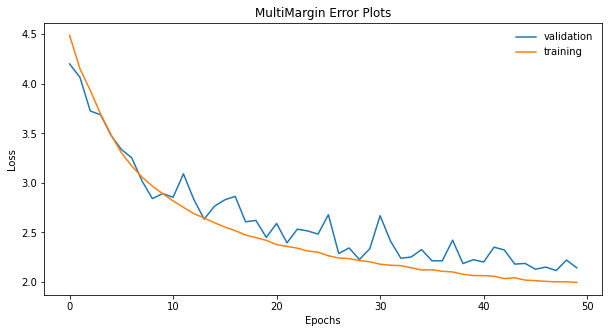

In [219]:
plt.figure(figsize=(10,5))
plt.plot(valid_losses, label = "validation")
plt.plot(train_losses, label = "training")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MultiMargin Error Plots')
plt.legend(frameon=False)
plt.savefig('expt8_error')

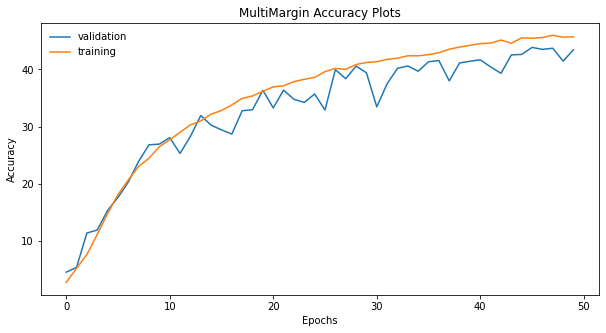

In [220]:
plt.figure(figsize=(10,5))
plt.plot(vals_acc, label = "validation")
plt.plot(trains_acc, label = "training")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MultiMargin Accuracy Plots')
plt.legend(frameon=False)
plt.savefig('expt8_accuracy.png')

In [221]:
total_correct = 0
total_images = 0
m1 = Model().to(device)
m1.load_state_dict(torch.load(model_path, map_location=device))
m1.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device),labels.to(device)
        outputs = m1(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        
model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 46.16%
